<a href="https://colab.research.google.com/github/zahra75koosha/zahra-koosha/blob/master/digit_dataset_hoda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 uninstall tensorflow
!pip3 install tensorflow.gpu==2.0.0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/My Drive/hoda
%ls

/content/drive/My Drive/hoda
hoda_dataset_helper.py  __pycache__/  RemainingSamples.cdb  test/  train/


In [0]:
from hoda_dataset_helper import read_hoda
from hoda_dataset_helper import __read_hoda_dataset
from hoda_dataset_helper import __read_hoda_cdb

import os
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline
np.random.seed(2)

from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import regularizers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten

Reading Train , Test , Remain dataset


In [0]:
# Reading train dataset 
X_train, Y_train = __read_hoda_dataset(dataset_path='./train/Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False ,
                                reshape=False)

# reading test dataset
X_test, Y_test = __read_hoda_dataset(dataset_path='./test/Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=False)

# Reading remain dataset
X_remain, Y_remain = __read_hoda_dataset('./RemainingSamples.cdb',
                                             images_height=32,
                                             images_width=32,
                                             one_hot=False,
                                             reshape=False)

In [0]:
# concat train and remain dataset
x_train=np.concatenate([X_train, X_remain])
y_train=np.concatenate([Y_train,Y_remain])


In [485]:
print(f'Number of the train samples are : {x_train.shape}')
print(f'Number of the test samples are : {X_test.shape}')


Number of the train samples are : (82352, 32, 32, 1)
Number of the test samples are : (20000, 32, 32, 1)


Preprocessing

In [0]:
# rescale data
x_train = x_train / 255.0
X_test = X_test /255.0


In [0]:
# Convert class vectors to binary class matrices.
y_train  =   to_categorical(y_train, num_classes = 10)
Y_test   =   to_categorical(Y_test, num_classes = 10)


In [488]:
print(f'shape of Y_train : {y_train.shape}')
print(f'shape of Y_test : {Y_test.shape}')

shape of Y_train : (82352, 10)
shape of Y_test : (20000, 10)


Split train dataset to train and validation 

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val= train_test_split(x_train,y_train,test_size=0.1, random_state=2, shuffle=True)

In [490]:
print(f'Number of the validation samples are : {x_val.shape}')
print(f'Shape of Y_val : {y_val.shape}')

Number of the validation samples are : (8236, 32, 32, 1)
Shape of Y_val : (8236, 10)


Data Augmentation

In [491]:
'''from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range=0.2,
                                  rescale=1./255
)
data_generator.fit(x_train)'''

'from tensorflow.keras.preprocessing.image import ImageDataGenerator\ndata_generator = ImageDataGenerator(rotation_range=0.2,\n                                  rescale=1./255\n)\ndata_generator.fit(x_train)'

Visual data

In [0]:
# reading train image
train_images, train_labels = __read_hoda_cdb('./train/Train 60000.cdb')

# reading test image
test_images, test_labels = __read_hoda_cdb('./test/Test 20000.cdb')

# reading train image
remaining_images, remaining_labels = __read_hoda_cdb('./RemainingSamples.cdb')


In [0]:
train_img =np.concatenate([train_images,remaining_images])
label_img =np.concatenate([train_labels,remaining_labels])

In [494]:
train_img.shape

(82352,)

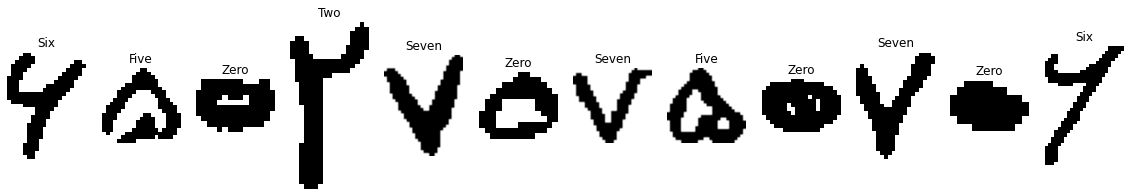

In [495]:
CLASS_NAMES = np.array(['zero','one','two', 'three','four','five','six', 'seven', 'eight',  'nine',])

plt.figure(figsize=(20,10))
for n in range(12):
      ax = plt.subplot(1,12,n+1)
      plt.imshow(train_img[n], cmap=plt.cm.Greys)
      plt.title(CLASS_NAMES[label_img[n]].title())
      plt.axis('off')


CNN Model

In [509]:


model= Sequential()

# block 1
model.add(Conv2D(32,(5,5), activation='relu', padding='same', input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

# block 2
model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# block 3
model.add(Conv2D(32,(3,3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu' , kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 8, 8, 32)        

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping=tf.keras.callbacks.EarlyStopping(patience=4, monitor="val_accuracy")
#tensor_board= tf.keras.callbacks.TensorBoard(log_dir='./logs')

lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=4, 
                        verbose=1, 
                        factor=0.3 ,
                        min_lr=0.00001)

my_callbacks=[lrr, early_stopping]





In [0]:
# set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [513]:
# train model
epochs = 16
batch_size = 32
result=model.fit(x_train, y_train,epochs=epochs, batch_size=batch_size, validation_data=(x_val,y_val), verbose=1, callbacks=my_callbacks)

Train on 74116 samples, validate on 8236 samples
Epoch 1/16
74116/74116 [==============================] - 32s 425us/sample - loss: 1.2089 - accuracy: 0.8776 - val_loss: 0.2998 - val_accuracy: 0.9580
Epoch 2/16
74116/74116 [==============================] - 31s 419us/sample - loss: 0.2301 - accuracy: 0.9635 - val_loss: 0.1721 - val_accuracy: 0.9700
Epoch 3/16
74116/74116 [==============================] - 31s 413us/sample - loss: 0.1462 - accuracy: 0.9747 - val_loss: 0.1222 - val_accuracy: 0.9796
Epoch 4/16
74116/74116 [==============================] - 31s 414us/sample - loss: 0.1138 - accuracy: 0.9798 - val_loss: 0.0926 - val_accuracy: 0.9846
Epoch 5/16
74116/74116 [==============================] - 31s 416us/sample - loss: 0.0961 - accuracy: 0.9828 - val_loss: 0.0835 - val_accuracy: 0.9874
Epoch 6/16
74116/74116 [==============================] - 31s 414us/sample - loss: 0.0851 - accuracy: 0.9851 - val_loss: 0.0813 - val_accuracy: 0.9864
Epoch 7/16
74116/74116 [=====================

In [514]:
model.evaluate(X_test, Y_test, verbose=1)

20000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06245535525083542, 0.98875]

In [515]:
model.evaluate(x_val, y_val, verbose=1)

8236/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05392599830086397, 0.9910151]

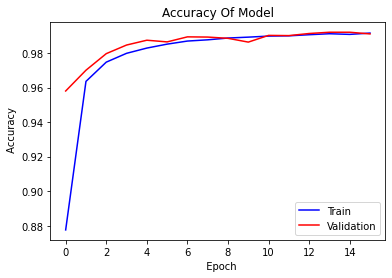

In [516]:
# plot train and validation accuracy

plt.plot(result.history['accuracy'], color='b', label='training accuracy')
plt.plot(result.history['val_accuracy'], color='r', label='validation accuracy')
plt.title('Accuracy Of Model')
plt.ylabel(' Accuracy')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

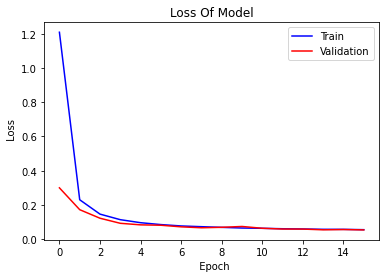

In [517]:
# plot train and validation accuracy

plt.plot(result.history['loss'], color='b', label='training loss')
plt.plot(result.history['val_loss'], color='r', label='validation loss')
plt.title('Loss Of Model')
plt.ylabel(' Loss')
plt.xlabel('  Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
import pandas as pd

results = model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results)

In [521]:
results

0        0
1        0
2        0
3        0
4        0
        ..
19995    9
19996    9
19997    9
19998    9
19999    9
Length: 20000, dtype: int64

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_digit_dataset.csv",index=False)